# Graph Attention Network

__Arthur Merode Germano__

## Explicação

__Graph Attention Network__ (GAT) é um modelo de inteligência artificial, baseado em Graph Neural Network (GNN) que busca aprimorar os *embeddings*. O GAT emprega o mecanismo de __attention__ para atribuir diferentes pesos aos nós e às arestas do grafo, com base em sua relevância para a tarefa em questão.

### Como funciona

Inicialmente temos um grafo com __N__ nodos, onde cada nodo é representado como um vetor $h_i$ com __F__ features

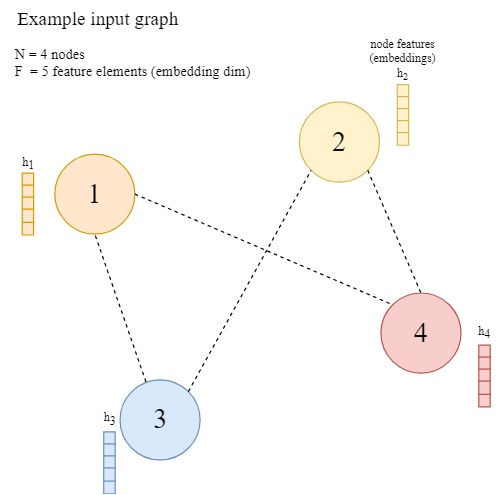
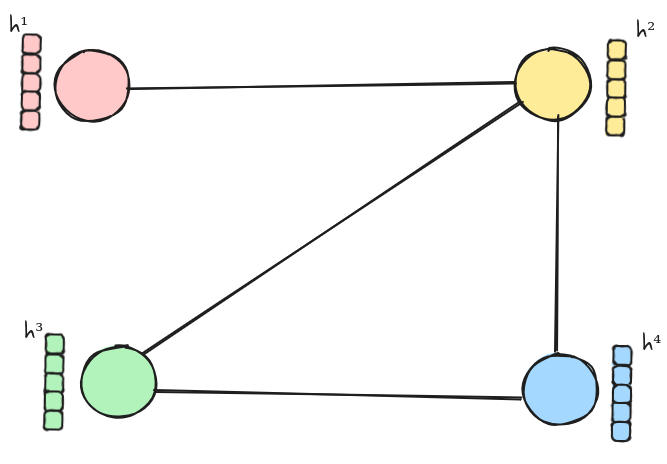

Sabendo disto, temos como entrada da nossa camada uma lista de característica dos nodos $h = \{h_1,h_2,h_3,h_4\} $, esta camada ela irá retornar uma nova lista de características  $h' = \{h'_1,\,h'_2,\,h'_3,\,h'_4\}$ mais estruturada e com mais contexto dos seus vizinhos.

Para fazer isso então, é necessário fazer *pelo menos* uma transformação linear (multiplicar por uma matri de pesos __W__)

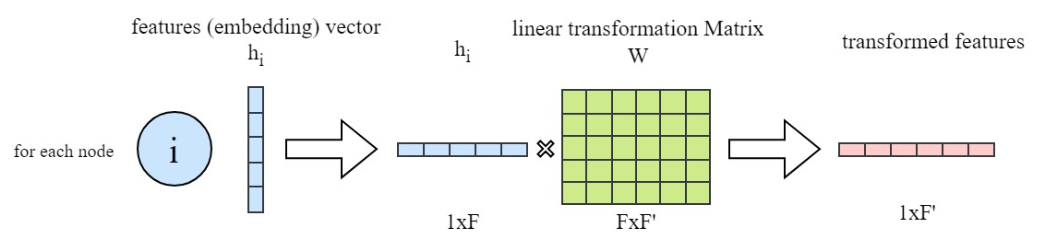

A diferença entre um GNN e um GAT está na etapa entre calcular as features transformadas ($h_i$ X W) e retorná-las para os nodos, pois após fazer a transformação linear, se aplica *self attention* para cada nodo, onde irá computar os *coeficientes de atenção*
$$
\Large
e_{ij} = a\bigl(W\vec{h}_i,\;W\vec{h}_j\bigr)
$$
O $a$ é um "*single-layer feedforward neural network*" (função da atenção) parâmetrizada por uma matriz de pesos $\vec{\mathbf{a}}$ com uma ativação $LeakyReLU$ para aplicar a não-linearidade.
$$\Large
  a = \mathrm{LeakyReLU}\bigl(\vec{\mathbf{a}}^T\,[\,W\vec{h}_i \Vert W\vec{h}_j\,]
$$
Isto nos indica a importância das features de j no nodo i. Porém desta maneira considera que todos os nós estão conectados, para que se mantenha a estrutra inicial do grafo calculamos $ e_{ij}$​ apenas para os nós $j∈ \mathcal{N}_i$​, onde $\mathcal{N}_i$​ é a vizinhança do nó $i$ no grafo. Para tornar os coeficientes facilmente comparáveis entre diferentes nós,  normalizam os coeficientes considerando todas as escolhas de $j$ por meio da função $softmax$
$$\Large
\alpha_{ij} = \mathrm{softmax}_j(e_{ij})
=
\frac{\exp(e_{ij})}
     {\displaystyle\sum_{k\in\mathcal{N}_i}\!\exp(e_{ik})}
$$
Expandindo a função, no final teremos que os coefiencientes computados pelo mecânismo de atenção são expressados como:
$$\Large
\alpha_{ij}
=
\frac{
  \exp\!\Bigl(\mathrm{LeakyReLU}\bigl(\vec{\mathbf{a}}^T\,[\,W\vec{h}_i \Vert W\vec{h}_j\,]\bigr)\Bigr)
}
{
  \displaystyle\sum_{k\in\mathcal{N}_i}
  \exp\!\Bigl(\mathrm{LeakyReLU}\bigl(\vec{\mathbf{a}}^T\,[\,W\vec{h}_i \Vert W\vec{h}_k\,]\bigr)\Bigr)
}
$$
|| = concatenação




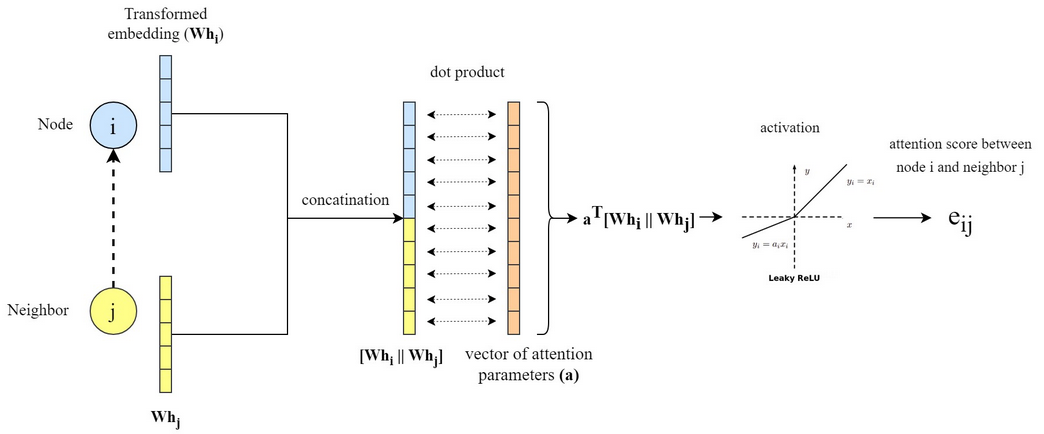

Então após obter os coeficientes de atenção normalizados, utilizamos eles para combinar a combinação linear das features correspondentes, para então ter a saída final para cada nodo:
$$\Large
\vec{h}'_i
= 
\sigma\!\Bigl(\sum_{j\in\mathcal{N}_i}\alpha_{ij}\,W\vec{h}_j\Bigr)\,
$$


### Multi-Head Attention

Para estabilizar o processo de aprendizagem de *self-attention*,estender nosso mecanismo para empregar atenção de *multi-head* é benéfico. Especificamente, $K$ mecanismos de atenção independentes executam a transformação a cima, em seguida, suas características são concatenadas, retornando em um $h'$ de tamanho $KF'$, resultando na seguinte representação de saída de características:
$$\Large
\vec{h}'_i
=
\big\Vert_{k=1}^K\;
\sigma\!\Bigl(\sum_{j\in\mathcal{N}_i}\alpha_{ij}^{(k)}\,W^{(k)}\vec{h}_j\Bigr)
$$


Especialmente se utilizar *multi-head* na camada de predição a concatenação não faz sentido, então neste caso se aplica a média e aplicação da não-linearidade:
$$\Large
\vec{h}'_i
=
\sigma\!\Bigl(\tfrac{1}{K}\sum_{k=1}^K\sum_{j\in\mathcal{N}_i}\alpha_{ij}^{(k)}\,W^{(k)}\vec{h}_j\Bigr)\,.
$$


## Aplicação

### Estimando probabilidadde de vitória no Esports

Nesta tarefa de predição, buscamos predizer o vencedor de um round no jogo Counter-Strike: Global Offensive (CSGO)

CSGO é um jogo de tiro tático em que duas equipes de cinco jogadores se enfrentam: os Terroristas (T) e os Contra-Terroristas (CT). O objetivo dos Terroristas é plantar uma bomba em um dos dois bombsites; os CTs, além de eliminar todos os adversários, devem impedir o plantio ou desarmar a bomba em até 40 segundos após o armamento.

Cada partida é disputada em até 24 rounds, cada um com duração de 1 minuto e 45 segundos. Nas doze primeiras rodadas, cada lado joga como T ou CT; no 13.º round, as equipes invertem os papéis (quem era T passa a ser CT, e vice-versa).

Antes de cada round, as equipes usam o dinheiro ganho em rodadas anteriores para comprar armas, coletes e utilitários. Um round é vencido quando:

* Os Terroristas detonam a bomba;

* Uma equipe eliminar toda a equipe adversária;

* O tempo expira sem o armamento da bomba (neste caso, vencem os CTs);

* Os CTs desarmam a bomba no prazo de 40 segundos após o plantio.

Com isso, a equipe que alcançar primeiro 13 vitórias ganha a partida.

Considere um estado de jogo $G_r^t$​ que ocorre no round $r$ no instante $t$. O round $r$ está associado a um resultado $Y_r$​, que vale 1 se o lado CT vence o round, e 0 se o lado CT perde. A tarefa de predição resultante é estimar
$$\Large
Pr⁡(Y_r=1∣G_r^t)
$$

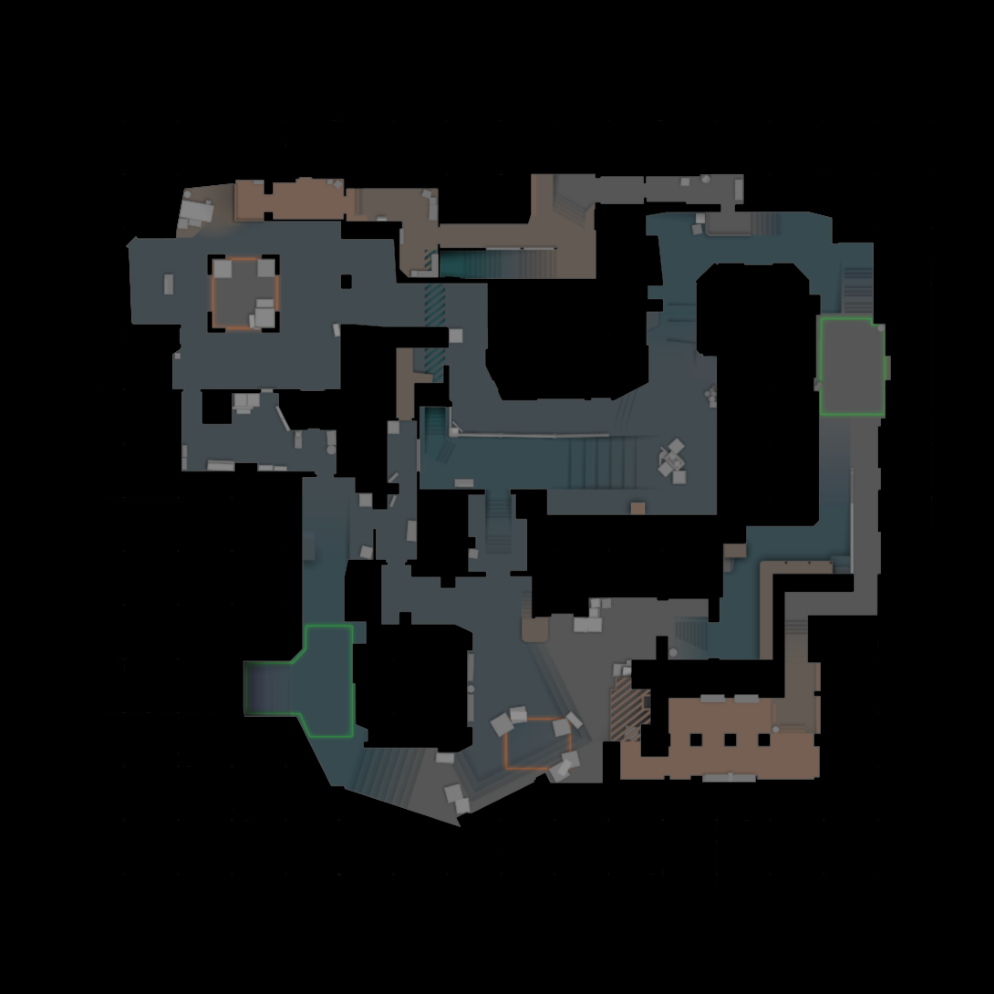

### Bibliotecas

In [ ]:
%pip install awpy
%pip install --force-reinstall "numpy[all]>=1.26.0,<2.2.0"
%pip install torch_geometric

In [209]:
import pandas as pd
import numpy as np
import warnings 
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from awpy import Demo
from awpy.plot import plot, PLOT_SETTINGS
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch_geometric.nn import GATConv, global_mean_pool
from sklearn.model_selection import train_test_split

### Dados
Para os dados foi utilizado demos de jogos oficiais em LAN somente no mapa *Mirage*, como os mapas mudam bastante de um para o outro, tem que fazer um modelo para cada mapa.

In [121]:
files = os.listdir('games')
df = pd.DataFrame()
list_dfs = []
for i, file in enumerate(files):
    try:
        dem = Demo(f"games/{file}", verbose=True,tickrate=128)
    
        dem.parse(player_props=["X","Y","Z","health","inventory","has_helmet","has_defuser","side","current_equip_value","round_start_equip_value","armor_value","score","is_bomb_planted","is_alive","team_num","is_defusing","in_bomb_zone"])
        df_temp = dem.ticks.to_pandas()
        df_temp = df_temp.loc[df_temp["tick"]%128 == 0]
        df_temp['game_num'] = i
        round_winner = dem.rounds['winner'].to_pandas()
        round_winner = (round_winner.values == 'ct').astype(int)
        df_temp['winner'] = df_temp['round_num'].apply(lambda x: round_winner[x - 1] if x - 1 < len(round_winner) else np.nan)
        list_dfs.append(df_temp)

    except Exception as e:
       print(e) 
       break
df = pd.concat(list_dfs, ignore_index=True)


2025-06-10 02:58:44.397 | DEBUG    | awpy.demo:parse:220 - Starting to parse games/faze-vs-legacy-m1-mirage.dem
2025-06-10 02:58:59.659 | SUCCESS  | awpy.demo:parse:271 - Finished parsing games/faze-vs-legacy-m1-mirage.dem, took 15.26 seconds
2025-06-10 02:59:01.196 | DEBUG    | awpy.demo:parse:220 - Starting to parse games/flyquest-vs-tyloo-m2-mirage.dem
2025-06-10 02:59:12.675 | SUCCESS  | awpy.demo:parse:271 - Finished parsing games/flyquest-vs-tyloo-m2-mirage.dem, took 11.48 seconds
2025-06-10 02:59:14.611 | DEBUG    | awpy.demo:parse:220 - Starting to parse games/chinggis-warriors-vs-fluxo-m2-mirage.dem
2025-06-10 02:59:31.238 | SUCCESS  | awpy.demo:parse:271 - Finished parsing games/chinggis-warriors-vs-fluxo-m2-mirage.dem, took 16.63 seconds
2025-06-10 02:59:33.685 | DEBUG    | awpy.demo:parse:220 - Starting to parse games/faze-vs-bcgame-m1-mirage.dem
2025-06-10 02:59:50.300 | SUCCESS  | awpy.demo:parse:271 - Finished parsing games/faze-vs-bcgame-m1-mirage.dem, took 16.61 second

### Feature Engineering

In [122]:
"""
    High Explosive Grenade - he,
    Smoke Grenade - smoke,
    Molotov - molotov,
    Incendiary Grenade - incendiary,
    Decoy Grenade - decoy,
    Flashbang - flash
"""

df['he'] = df['inventory'].apply(lambda x: 1 if 'High Explosive Grenade' in x else 0)
df['smoke'] = df['inventory'].apply(lambda x: 1 if 'Smoke Grenade' in x else 0)
df['molotov'] = df['inventory'].apply(lambda x: 1 if 'Smoke Molotov' in x else 0)
df['incendiary'] = df['inventory'].apply(lambda x: 1 if 'Incendiary Grenade' in x else 0)
df['flash'] = df['inventory'].apply(lambda x: 1 if 'Flashbang' in x else 0)
df['decoy'] = df['inventory'].apply(lambda x: 1 if 'Decoy Grenade' in x else 0)
df.drop(columns=['inventory'],inplace=True)
df

,is_bomb_planted,score,health,team_num,has_defuser,has_helmet,place,in_bomb_zone,is_defusing,armor,...,name,round_num,game_num,winner,he,smoke,molotov,incendiary,flash,decoy
0,False,0,100.0,3.0,False,False,CTSpawn,False,False,0.0,...,frozen,1,0,0,0,0,0,0,0,0
1,False,0,100.0,2.0,False,False,TSpawn,False,False,0.0,...,latto,1,0,0,0,0,0,0,0,0
2,False,0,100.0,3.0,False,False,CTSpawn,False,False,0.0,...,karrigan,1,0,0,0,0,0,0,0,0
3,False,0,100.0,2.0,False,False,TSpawn,False,False,0.0,...,lux,1,0,0,0,0,0,0,0,0
4,False,0,100.0,2.0,False,False,TSpawn,False,False,0.0,...,saadzin,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86975,False,50,0.0,3.0,False,False,CTSpawn,False,False,0.0,...,Wicadia,22,6,1,0,0,0,0,0,0
86976,False,28,0.0,3.0,False,False,SnipersNest,False,False,0.0,...,woxic,22,6,1,0,0,0,0,0,0
86977,False,46,99.0,3.0,True,True,PalaceInterior,False,False,85.0,...,XANTARES,22,6,1,1,0,0,1,0,0
86978,False,37,0.0,2.0,False,False,BombsiteA,False,False,0.0,...,LNZ,22,6,1,0,0,0,0,0,0


### Criação do grafo

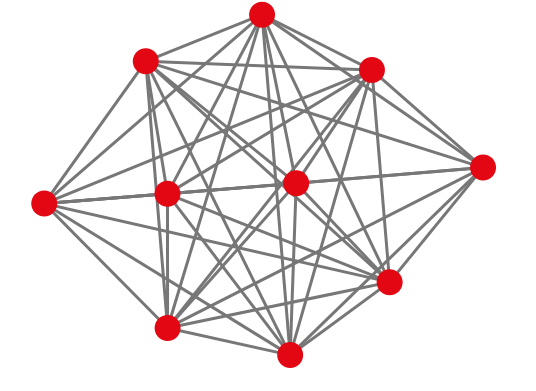

In [123]:

ct_spawn = np.array([-1516.3, -1335.9, -259.97])   # CT Spawn
t_spawn  = np.array([1414.7,    27.6,  -167.97])   # T Spawn
site_a   = np.array([-580.9,  -2159.5, -179.97])   # Bombsite A
site_b   = np.array([-1700.0,   500.0, -230.0])    # Bombsite B 
graph_data_list = []

for game_num in range(len(os.listdir("games"))):
    temp_df = df.loc[df['game_num'] == game_num]
    players = sorted(temp_df.steamid.unique())
    for i,tick in enumerate(sorted(temp_df.tick.unique())):
        state = df.loc[(df['tick']==tick) & (df['game_num'] == game_num)].set_index('steamid').loc[players]
        node_features = []
        try:
            for _, row in state.iterrows():
                pos = np.array([row['X'], row['Y'], row['Z']])
                dist_a = np.linalg.norm(pos - site_a)
                dist_b = np.linalg.norm(pos - site_b)
                try:
                    feats = [
                        row['X'], row['Y'], row['Z'],
                        row['health'], row['armor'],
                        row['current_equip_value'], row['round_start_equip_value'],
                        row['he'], row['smoke'],row['flash'],row['molotov'],row['incendiary'],row['decoy'],
                        dist_a, dist_b,
                        int(row['in_bomb_zone']),
                        int(row['is_alive']),
                        int(row['has_helmet']),
                        int(row['has_defuser']),
                        1 if row['side'].lower() == 'ct' else 0
                    ]
                except Exception as e:
                    print(f'Tick {tick}, from game {game_num} invalid')
                    raise e
                node_features.append(feats)
        except Exception as e:
            print(e)
            continue

        x = torch.tensor(node_features, dtype=torch.float)
        edge_index = torch.tensor([[i, j] for i in range(10) for j in range(10)], dtype=torch.long).t().contiguous()
        y = torch.tensor(state['winner'].iloc[0], dtype=torch.float)

        graph_data = Data(x=x, edge_index=edge_index, y=y)
        graph_data.num_nodes = x.shape[0]
        graph_data_list.append(graph_data)

print("Total Graphs: ", len(graph_data_list))
print("Players per Graph: ", 10)
print("Node Feature Size: ", x.shape[1])
print("y por grafo:", y.shape, y)

Tick 53504, from game 3 invalid
int() argument must be a string, a bytes-like object or a real number, not 'NoneType'
Tick 53632, from game 3 invalid
int() argument must be a string, a bytes-like object or a real number, not 'NoneType'
Total Graphs:  8696
Players per Graph:  10
Node Feature Size:  20
y por grafo: torch.Size([]) tensor(1.)


### Separação entre treino (70%), validação (10%) e teste (20%)

In [124]:
train_val_graphs, test_graphs = train_test_split(graph_data_list, test_size=0.2, random_state=42)
train_graphs, val_graphs = train_test_split(train_val_graphs, test_size=0.125, random_state=42)

In [125]:
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32)
test_loader = DataLoader(test_graphs, batch_size=32)

### Criação do modelo

In [ ]:
class CSGOGAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels = None):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=1)
        self.gat2 = GATConv(hidden_channels, out_channels, heads=1)
        self.fc = nn.Linear(out_channels, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.fc(x)


In [131]:
model = CSGOGAT(in_channels=20, hidden_channels=32, out_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

### Métodos de treinamento e avalliação

In [128]:
from sklearn.metrics import roc_auc_score

def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch).view(-1)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(train_loader.dataset)

def evaluate(loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            out = model(batch).view(-1)
            loss = criterion(out, batch.y.view(-1))
            total_loss += loss.item() * batch.num_graphs
            probs = torch.sigmoid(out)
            all_preds.extend(probs.tolist())
            all_labels.extend(batch.y.tolist())
    auc = roc_auc_score(all_labels, all_preds)
    return total_loss / len(loader.dataset), auc


In [132]:
results = []
for epoch in range(1, 1000):
    train_loss = train()
    if epoch % 10 == 0:
      val_loss, val_auc = evaluate(val_loader)
      test_loss, test_auc = evaluate(test_loader)
      results.append((epoch, train_loss, val_loss, val_auc))

results_df = pd.DataFrame(results, columns=["Epoch", "Train Loss", "Val Loss", "Val AUC"])
results_df.loc[len(results_df)] = ["TEST", None, test_loss, test_auc]


In [133]:
results_df

,Epoch,Train Loss,Val Loss,Val AUC
0,10,1.300771,1.199912,0.683435
1,20,1.009810,1.646729,0.721911
2,30,0.916738,2.108401,0.670486
3,40,0.790678,0.762736,0.747280
4,50,0.738909,0.621246,0.752562
...,...,...,...,...
95,960,0.404540,0.547641,0.848160
96,970,0.478058,0.491633,0.831271
97,980,0.425665,0.473611,0.857949
98,990,0.464601,0.508223,0.834002


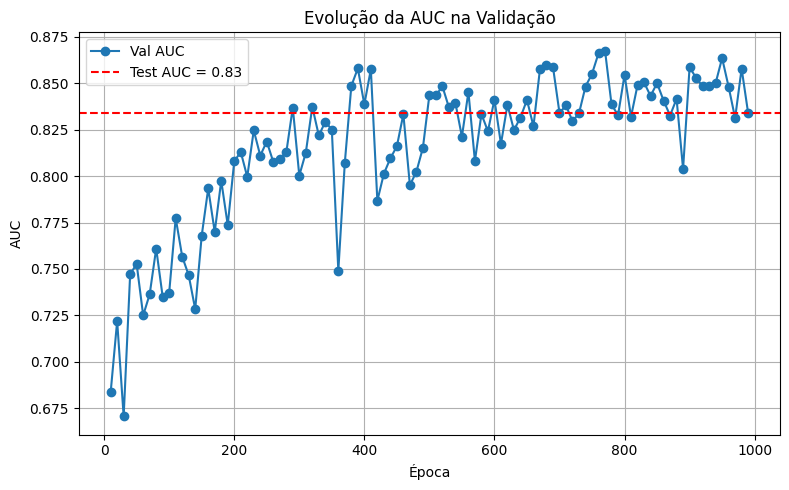

In [134]:
plt.figure(figsize=(8, 5))
results_df['AUC Smoothed'] = results_df['Val AUC'].rolling(window=100).mean()
epochs = results_df[results_df["Epoch"] != "TEST"]["Epoch"].astype(int)
auc_values = results_df[results_df["Epoch"] != "TEST"]["Val AUC"].astype(float)

plt.plot(epochs, auc_values, marker='o', label="Val AUC")
plt.axhline(test_auc, color='r', linestyle='--', label=f"Test AUC = {test_auc:.2f}")
plt.title("Evolução da AUC na Validação")
plt.xlabel("Época")
plt.ylabel("AUC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [144]:
dem_predict = Demo('gamerlegion-vs-g2-m2-mirage.dem',tickrate=128, verbose=True)
dem_predict.parse(player_props=["X","Y","Z","health","inventory","has_helmet","has_defuser","side","current_equip_value","round_start_equip_value","armor","score","is_bomb_planted","is_alive","team_num","is_defusing","in_bomb_zone"])
df_predict = dem_predict.ticks.to_pandas()
df_predict = df_predict.loc[df_predict["tick"]%128 == 0]

df_predict['he'] = df_predict['inventory'].apply(lambda x: 1 if 'High Explosive Grenade' in x else 0)
df_predict['smoke'] = df_predict['inventory'].apply(lambda x: 1 if 'Smoke Grenade' in x else 0)
df_predict['molotov'] = df_predict['inventory'].apply(lambda x: 1 if 'Smoke Molotov' in x else 0)
df_predict['incendiary'] = df_predict['inventory'].apply(lambda x: 1 if 'Incendiary Grenade' in x else 0)
df_predict['flash'] = df_predict['inventory'].apply(lambda x: 1 if 'Flashbang' in x else 0)
df_predict['decoy'] = df_predict['inventory'].apply(lambda x: 1 if 'Decoy Grenade' in x else 0)
df_predict.drop(columns=['inventory'],inplace=True)

ct_spawn = np.array([-1516.3, -1335.9, -259.97])   # CT Spawn
t_spawn  = np.array([1414.7,    27.6,  -167.97])   # T Spawn
site_a   = np.array([-580.9,  -2159.5, -179.97])   # Bombsite A
site_b   = np.array([-1700.0,   500.0, -230.0])    # Bombsite B 
graph_data_list = []

players = sorted(df_predict.steamid.unique())

for tick in sorted(df_predict.tick.unique()):
    try:
        state = df_predict[df_predict["tick"] == tick].set_index("steamid").loc[players]
    except:
        continue  # skip ticks com menos de 10 jogadores

    node_features = []
    for _, row in state.iterrows():
        pos = np.array([row['X'], row['Y'], row['Z']])
        dist_a = np.linalg.norm(pos - site_a)
        dist_b = np.linalg.norm(pos - site_b)

        feats = [
            row['X'], row['Y'], row['Z'],
            row['health'], row['armor'],
            row['current_equip_value'], row['round_start_equip_value'],
            row['he'], row['smoke'], row['flash'],
            row['molotov'], row['incendiary'], row['decoy'],
            dist_a, dist_b,
            int(row['in_bomb_zone']),
            int(row['is_alive']),
            int(row['has_helmet']),
            int(row['has_defuser']),
            1 if row['side'] == 'ct' else 0
        ]
        node_features.append(feats)

    if len(node_features) != 10:
        continue  # skip frames incompletos

    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor([[i, j] for i in range(10) for j in range(10)], dtype=torch.long).t().contiguous()

    graph_data = Data(x=x, edge_index=edge_index)
    graph_data.tick = tick
    graph_data_list.append(graph_data)



2025-06-10 03:22:58.405 | DEBUG    | awpy.demo:parse:220 - Starting to parse gamerlegion-vs-g2-m2-mirage.dem


2025-06-10 03:23:15.446 | SUCCESS  | awpy.demo:parse:271 - Finished parsing gamerlegion-vs-g2-m2-mirage.dem, took 17.04 seconds


In [212]:
def plot_map(graph_x,prob):
  x = graph_x.cpu().numpy()

  players = sorted(df_predict['steamid'].unique())
  name_map = df_predict.drop_duplicates("steamid").set_index("steamid")["name"].to_dict()
  player_names = [name_map.get(sid, f"Player_{i}") for i, sid in enumerate(players)]

  points = []
  point_settings = []

  for i, row in enumerate(x):
      if row[-3] != 1:  # is_alive == 1
          continue

      pos = (row[0], row[1], row[2])
      side = "ct" if row[-1] == 1 else "t"
      hp = row[3]
      armor = row[4]

      settings = PLOT_SETTINGS[side].copy()
      settings.update({
        "hp": int(hp),
        "armor": int(armor),
        "label": player_names[i],
        "color": "blue" if side == "ct" else "red"
      })

      points.append(pos)
      point_settings.append(settings)

  print(f"Probabilidade de vitória CT: {prob:.2%}")
  fig = plot(map_name="de_mirage", points=points, point_settings=point_settings)

Probabilidade de vitória CT: 61.48%


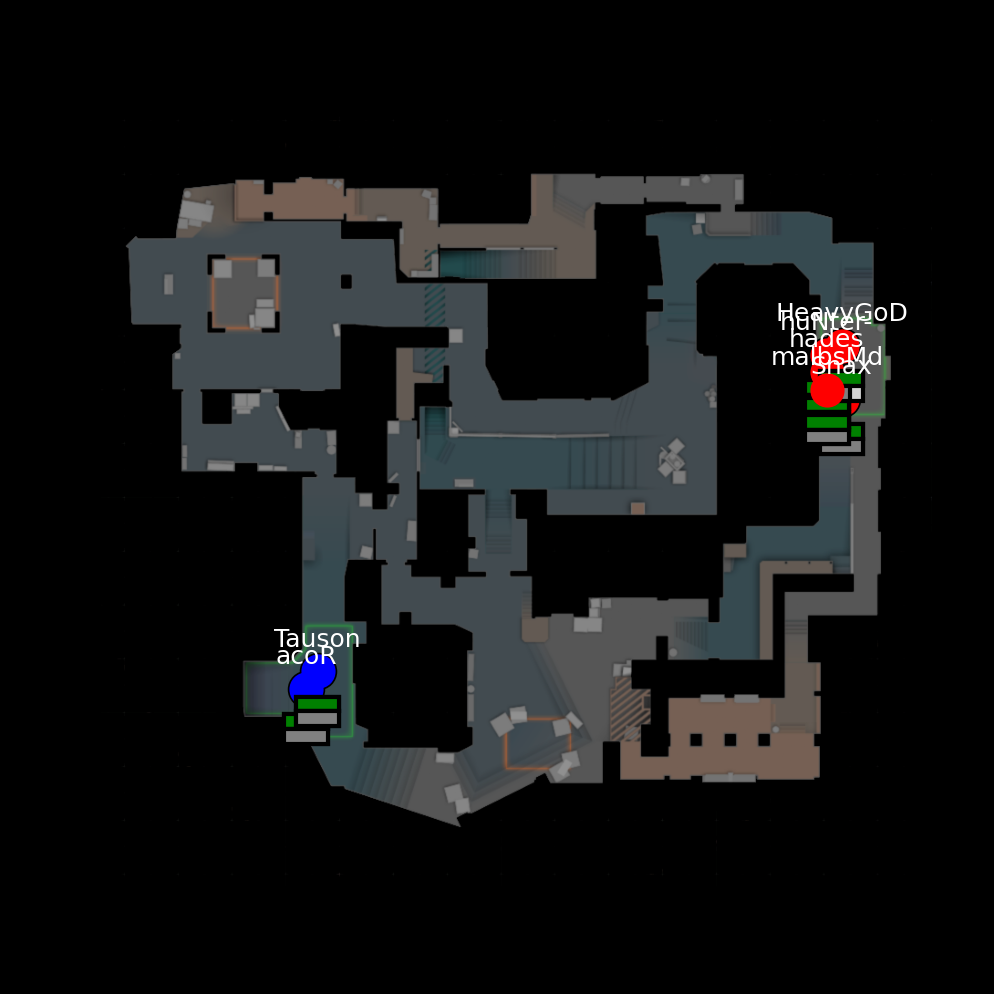

In [213]:
graph = graph_data_list[700] #spawn
graph = graph.to('cpu')

model.eval()
with torch.no_grad():
    batch = Batch.from_data_list([graph]).to('cpu')
    out = model(batch)
    prob = torch.sigmoid(out).item()
plot_map(graph.x,prob)

Probabilidade de vitória CT: 7.96%


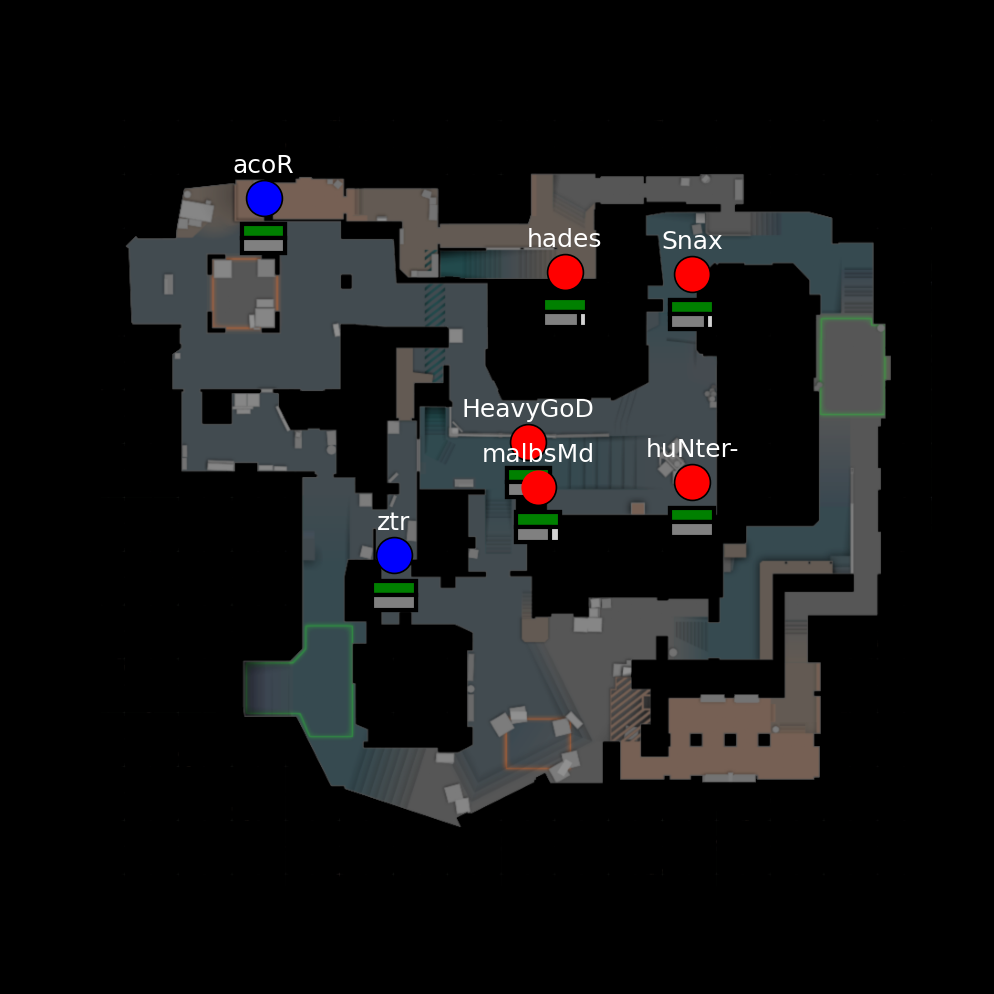

In [214]:
graph = graph_data_list[452]
graph = graph.to('cpu')

model.eval()
with torch.no_grad():
    batch = Batch.from_data_list([graph]).to('cpu')
    out = model(batch)
    prob = torch.sigmoid(out).item()
plot_map(graph.x,prob)

Probabilidade de vitória CT: 61.48%


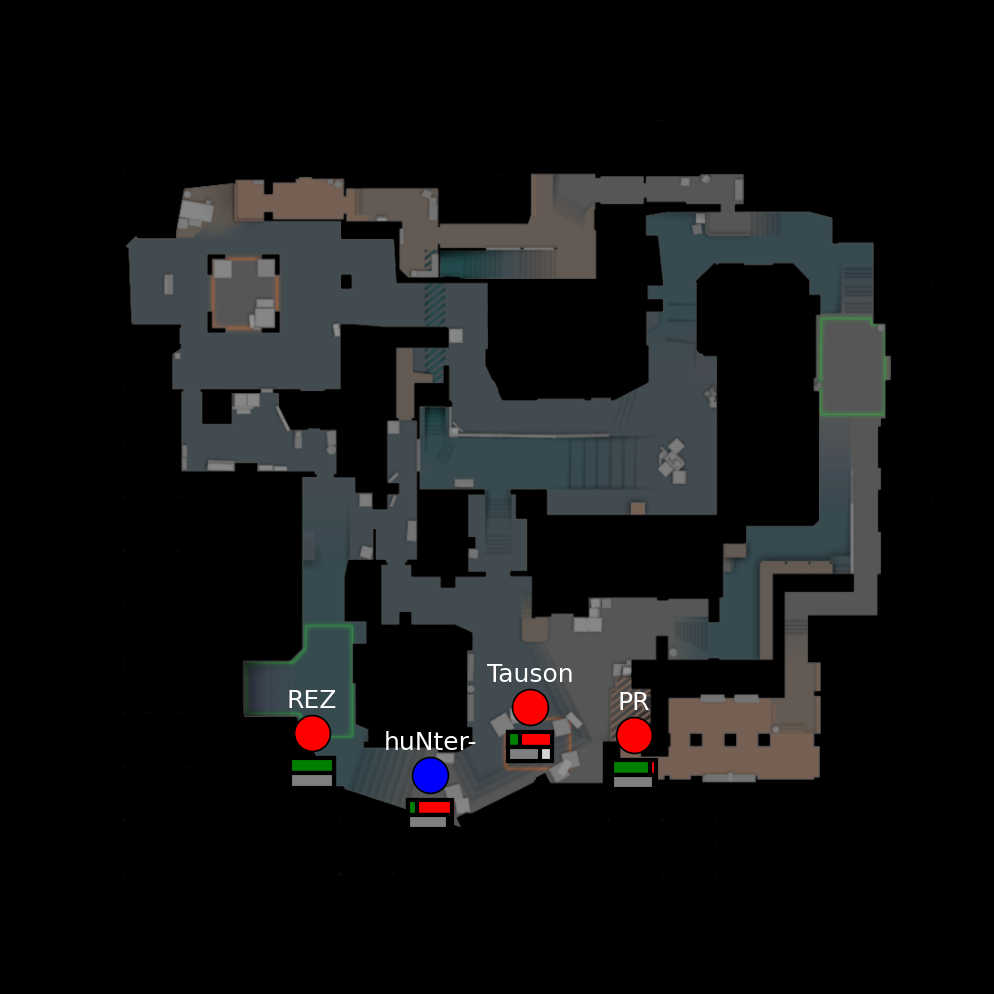

In [215]:
graph = graph_data_list[875]
graph = graph.to('cpu')

model.eval()
with torch.no_grad():
    batch = Batch.from_data_list([graph]).to('cpu')
    out = model(batch)
    prob = torch.sigmoid(out).item()
plot_map(graph.x,prob)